In [64]:
import pandas as pd
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import re;

# import excel data file
plate_test_xls = pd.ExcelFile('PLATE1_IZZY_TEST_2_PATIENTS_AND_STANDARD.xlsx');

plate_test_df = plate_test_xls.parse(0, skiprows=1)

In [65]:
# function to clean up Sample ID column into PatientID, Visit, Dilution columns
def clean_sample_id_column(df_plate):
    # this transforms the troublesome 'Sample ID' column into an array
    column1_array = df_plate['Sample ID'].values

    # taking mark's advice this list comprehension inverts the contents of each element (i.e. cell) in the array
    column1_array = [cell[::-1] for cell in column1_array]

    # cleaning up data
    rex = re.compile(r'(?:(?P<Dilution> *[0]+1) *)?(?:(?P<Visit> *[1-3][v|V] *))?(?P<PatientID>[ |[A-Za-z0-9_]+)')
    outputs = [rex.match(x) for x in column1_array]

    # this takes the named groups from the regular expression above converts everything into a list of dictionaries where
    # the keys are group names (PatientID, Visit and Dilution) and the values are the corresponding string components
    lst_of_dcts = []
    for i, o in enumerate(outputs):
        try:
            lst_of_dcts.append(o.groupdict())
        except:
            print(column1_array[i])

    # up until this point all the values we are interested in are still inverted from the cell[::-1]. This changes them back
    for dct in lst_of_dcts:
        for k, v in dct.items():
            if v == None:
                continue
            else:
                vv = v[::-1].strip()  # added the strip to take away any extra white space still attached
                dct[k] = vv

    # this deletes the old 'SampleID' column
    df_plate.drop('Sample ID', axis=1, inplace=True)

    # This block of code goes through the list of dictionaries and appends the values to a list of their specific category
    # e.g. a dilution of '100' is added to the dilution_list. These lists are then added to the dataframe as columns at
    # the specified index so they are at the front of the dataframe and not slapped on at the end.
    id_list = []
    visit_list = []
    dilution_list = []
    for dct in lst_of_dcts:
        id_list.append(dct['PatientID'])
        visit_list.append(dct['Visit'])
        dilution_list.append(dct['Dilution'])
    df_plate.insert(0, 'PatientID', id_list)
    df_plate.insert(1, 'Visit', visit_list)
    df_plate.insert(2, 'Dilution', dilution_list)

    # return new dataframe
    return df_plate;

In [66]:
clean_plate_test_df = clean_sample_id_column(plate_test_df)

In [67]:
# clean up column headers and reassign
clean_plate_test_df.columns = map(lambda x: x.strip(), clean_plate_test_df.columns);
    # fill in the info for hospital, age, gender according to existing data

clean_plate_test_df['Hospital'] = clean_plate_test_df['Hospital'].ffill();
clean_plate_test_df['Age'] = clean_plate_test_df['Age'].ffill();
clean_plate_test_df['Gender'] = clean_plate_test_df['Gender'].ffill();

clean_plate_test_df

,PatientID,Visit,Dilution,Hospital,Age,Gender,PSMalpha2,PSMalpha3,psmalpah4,BSA
0,Standard,None,10,NaN,NaN,NaN,3480,1678,2416,NaN
1,Standard,None,100,NaN,NaN,NaN,1811,1534,1342,NaN
2,Standard,None,1000,NaN,NaN,NaN,823,1073,677,NaN
3,Standard,None,10000,NaN,NaN,NaN,319,438,262,NaN
4,Standard,None,100000,NaN,NaN,NaN,126,170,113,NaN
5,Standard,None,1000000,NaN,NaN,NaN,77,89,64,NaN
6,Standard,None,10000000,NaN,NaN,NaN,47,45,33,NaN
7,23234,V1,100,Bellevue,60.0,M,959,1370,913,NaN
8,23234,V1,1000,Bellevue,60.0,M,551,835,585,NaN
9,23234,V1,10000,Bellevue,60.0,M,169,234,152,NaN


In [68]:
# group by patient id
patient_id = clean_plate_test_df.groupby("PatientID");
list(patient_id)

[('23234',
     PatientID Visit Dilution  Hospital   Age Gender  PSMalpha2  PSMalpha3  \
  7      23234    V1      100  Bellevue  60.0      M        959       1370   
  8      23234    V1     1000  Bellevue  60.0      M        551        835   
  9      23234    V1    10000  Bellevue  60.0      M        169        234   
  10     23234    V1   100000  Bellevue  60.0      M         67         77   
  11     23234    V2      100  Bellevue  60.0      M       1083       1631   
  12     23234    V2     1000  Bellevue  60.0      M        609       1015   
  13     23234    V2    10000  Bellevue  60.0      M        242        367   
  14     23234    V2   100000  Bellevue  60.0      M         79        106   
  
      psmalpah4  BSA  
  7         913  NaN  
  8         585  NaN  
  9         152  NaN  
  10         65  NaN  
  11       1021  NaN  
  12        622  NaN  
  13        201  NaN  
  14         71  NaN  ),
 ('Standard',
    PatientID Visit  Dilution Hospital  Age Gender  PSMalpha2

In [69]:
def null_col(df):
    null_col_list = [col for col in df.columns if df[col].isnull().any()]
    okay_list = ['Visit', 'Dilution', 'Hospital', 'Age', 'Gender']
    null_list = list(set(null_col_list) - set(okay_list))
    print(null_list)
    
null_col(clean_plate_test_df)    # to test if fxn is working

['BSA']


In [70]:
plot_columns = ['PSMalpha2', 'PSMalpha3', 'psmalpah4','BSA'];

    # visit number color coding dictionary
visit_color = {"V1": "r", "V2": "b", "V3": "g"};

null_col_list = [col for col in clean_plate_test_df.columns if clean_plate_test_df[col].isnull().any()]
okay_list = ['Visit', 'Dilution', 'Hospital', 'Age', 'Gender']
null_list = list(set(null_col_list) - set(okay_list))

null_list

['BSA']

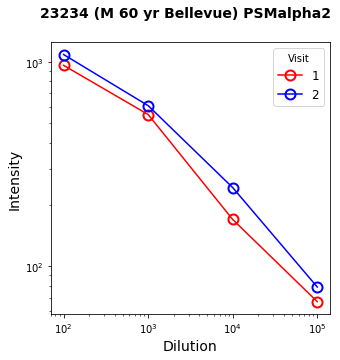

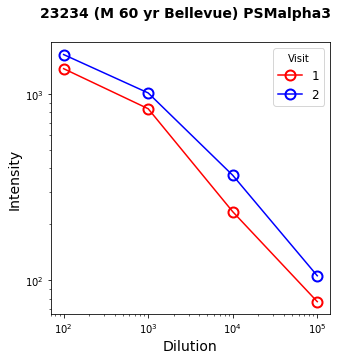

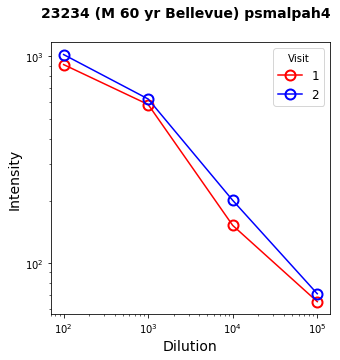

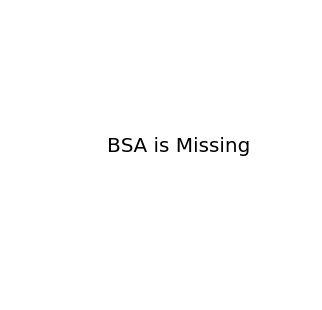

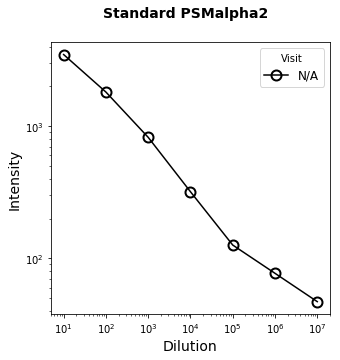

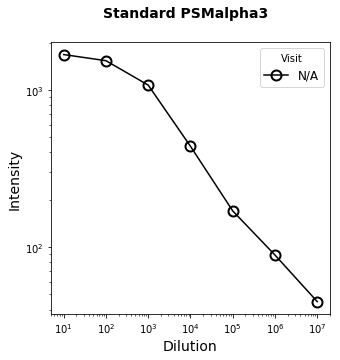

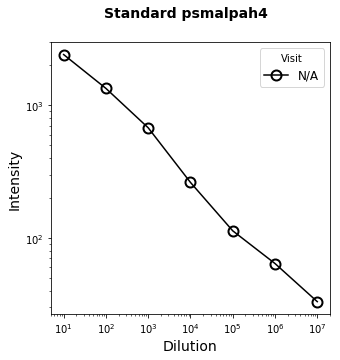

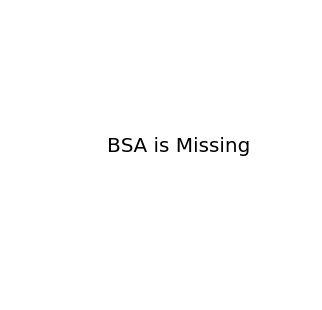

In [72]:
# group by patient id
for patient_name, patient_data in patient_id:
    for plot_col in plot_columns:
        plt.figure(figsize=(5, 5));
        plt_title = patient_name;
            
        if plot_col in null_list:
            missing_data_text = str(plot_col + ' is Missing')
            plt.loglog(patient_data["Dilution"], patient_data[plot_col], label=missing_data_text, color='w')
            plt.axis('off')
            plt.legend(frameon=False, loc=6, fontsize=20)
            
            # if it is a "standard" patient, plot with no other info or visits
        elif "Standard" in patient_name:
            patient_name = "Standard";
            plt_title = plt_title + " " + plot_col;
            plt.suptitle(plt_title, fontsize=14, fontweight='bold');
            plt.loglog(patient_data["Dilution"], patient_data[plot_col], color='k',
                           marker='o', markerfacecolor='none',
                           markersize=10,
                           markeredgewidth=2, label="N/A");
            plt.legend(title="Visit", loc=1, fontsize=12);
            plt.xlabel('Dilution', fontsize=14);
            plt.ylabel('Intensity', fontsize=14);

            # create title and assign it
        else:
            visits = patient_data.groupby("Visit");
            plt.xlabel('Dilution', fontsize=14);
            plt.ylabel('Intensity', fontsize=14);
            if plot_col not in null_list:
                           # create title and assign it
                plt_title = plt_title + " (" + patient_data["Gender"].iloc[0] + " " + str("%.f" % patient_data["Age"].iloc[0]) + " yr " + patient_data["Hospital"].iloc[0] + ") " + plot_col;
                plt.suptitle(plt_title, fontsize=14, fontweight='bold')
                for visit_name, visit_data in visits:
                    if visit_name == "None":
                        visit_name = "V1";
                # plotting with log axis, colors according to the visit_color dictionary
                    plt.loglog(visit_data["Dilution"], visit_data[plot_col], color=visit_color[visit_name.upper()],
                           marker='o', markerfacecolor='none',
                           markersize=10,
                           markeredgewidth=2, label=visit_name[1]);
                    plt.legend(title="Visit", loc=1, fontsize=12);
            # assigning other misc plot axis and legend information

            